Estimate impulse responses to word onset and surprisal in the Brennan 2018 dataset, controlling (hopefully eventually) for word acoustics.

In [72]:
import logging
logging.basicConfig(level=logging.DEBUG, handlers=[])
import os
from pathlib import Path
import re
from typing import List

from matplotlib import pyplot as plt

import mne
os.environ["MNE_TQDM"] = "off"
mne.set_log_level(logging.WARNING)

from mne.decoding import ReceptiveField
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.signal
import scipy.stats
from tqdm.notebook import tqdm

basedir = Path("..").resolve()
import sys
sys.path.append(str(basedir))

DATA_DIR = Path("/om/data/public/language-eeg/brennan2018-v2")

FILTER_WINDOW = (0.5, 20)
RF_WINDOW = (0.0, 0.90625)

SAMPLE_RATE_FOR_REGRESSION = 128

# TODO: What is right for this montage?
# N400_ELECTRODES = ["1", "14", "24", "25", "26", "29", "30", "31", "41", "42", "44", "45"]
# Picking some central sensors here, following Gillis
N400_ELECTRODES = ["45", "34", "35", "1"]

In [3]:
%load_ext autoreload
%autoreload 2

In [10]:
from mfn400.adapters.brennan2018 import BrennanDatasetAdapter
from mfn400.trf import TRFEstimator

In [50]:
data = BrennanDatasetAdapter(DATA_DIR)

loading subject data:   0%|          | 0/33 [00:00<?, ?it/s]

2022-08-04 10:55:09 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 1
2022-08-04 10:55:09 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 1
2022-08-04 10:55:12 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 3
2022-08-04 10:55:12 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 3
2022-08-04 10:55:14 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 4
2022-08-04 10:55:14 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 4
2022-08-04 10:55:17 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 5
2022-08-04 10:55:17 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 5
2022-08-04 10:55:19 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 6
2022-08-04 10:55:19 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 6
2022-08-04 10:55:21 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 8
2022-08-04 10:55:21 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 8
2022-08-04 10:55:24 | DEBUG 

In [51]:
data.run_preprocessing(filter_window=FILTER_WINDOW)

preprocessing subjects:   0%|          | 0/33 [00:00<?, ?it/s]

2022-08-04 10:56:29 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 1
2022-08-04 10:56:29 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 1
2022-08-04 10:56:30 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 3
2022-08-04 10:56:30 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 3
2022-08-04 10:56:31 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 4
2022-08-04 10:56:31 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 4
2022-08-04 10:56:32 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 5
2022-08-04 10:56:32 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 5
2022-08-04 10:56:33 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 6
2022-08-04 10:56:33 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 6
2022-08-04 10:56:34 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 8
2022-08-04 10:56:34 | DEBUG    | mfn400.ada

/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/broderick2018/mfn400/adapters/brennan2018.py:130: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw = raw.filter(*filter_window)


2022-08-04 10:56:42 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 17
2022-08-04 10:56:42 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 17
2022-08-04 10:56:43 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 18
2022-08-04 10:56:43 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 18
2022-08-04 10:56:44 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 19
2022-08-04 10:56:44 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 19
2022-08-04 10:56:45 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 20
2022-08-04 10:56:45 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 20
2022-08-04 10:56:46 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 21
2022-08-04 10:56:46 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 21
2022-08-04 10:56:47 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 22
2022-08-04 10:56:47 | DEBUG    |

In [47]:
# HACK: merge in control features computed from Alice repo.
# if this ends up working, we definitely need to merge in that code and clean this up.
predictors = np.load(DATA_DIR / "predictors.npz")
list(predictors.keys())

['1/gammatone-8',
 '2/gammatone-8',
 '3/gammatone-8',
 '4/gammatone-8',
 '5/gammatone-8',
 '6/gammatone-8',
 '7/gammatone-8',
 '8/gammatone-8',
 '9/gammatone-8',
 '10/gammatone-8',
 '11/gammatone-8',
 '12/gammatone-8']

In [16]:
def process_key(key_str):
    match = re.findall(r"^(\d+)/(.+)$", key_str)[0]
    return (int(match[0]), match[1])

In [58]:
def sanity_check_onsets(segment_onsets):
    # Sanity check: each segment's predictors should fit within the presentation time
    for key, value in predictors.items():
        segment, feature = process_key(key)
        duration = value[-1, 0] - value[0, 0]

        if segment in segment_onsets.index and segment + 1 in segment_onsets.index:
            assert duration < segment_onsets.loc[segment + 1] - segment_onsets.loc[segment]

def prepare_trf_inputs(subject_idx):
    presentation_df = data.get_presentation_data(subject_idx).copy()
    
    segment_onsets = presentation_df.groupby("segment_idx").segment_onset.min()
    sanity_check_onsets(segment_onsets)
    
    sample_times = predictors["1/gammatone-8"][:, 0]
    assert SAMPLE_RATE_FOR_REGRESSION == 1 / (sample_times[1] - sample_times[0]), \
        "Control features are not sampled at target rate for regression"
    
    raw = data._raw_data[subject_idx].pick_types(eeg=True).resample(SAMPLE_RATE_FOR_REGRESSION)
    Y = raw.get_data("eeg").T
    
    gammatone_features = [f"gammatone-{i+1}" for i in range(8)]
    presentation_features = ["word_onset", "word_surprisal", "word_logfreq", "sound_power"]
    n_features = len(gammatone_features) + len(presentation_features)

    X = np.zeros((Y.shape[0], n_features))
    presentation_df["sample_idx"] = np.floor(presentation_df.onset * raw.info["sfreq"]).astype(int)
    for segment_idx, segment_onset in segment_onsets.iteritems():
        segment_onset_sample = int(np.floor(segment_onset * raw.info["sfreq"]))

        # Add Gammatone data.
        gammatone_data = predictors[f"{segment_idx}/gammatone-8"][:, 1:]
        assert gammatone_data.shape[1] == 8
        X[segment_onset_sample:segment_onset_sample + gammatone_data.shape[0], :8] = gammatone_data

        # Word onset
        X[presentation_df.sample_idx, 8] = 1
        # X[presentation_df.sample_idx, 9] = presentation_df.IsLexical
        X[presentation_df.sample_idx, 9] = presentation_df.NGRAM
        X[presentation_df.sample_idx, 10] = presentation_df.LogFreq
        X[presentation_df.sample_idx, 11] = presentation_df.SndPower
        
    X[np.isnan(X)] = 0.
    feature_names = gammatone_features + presentation_features
        
    return feature_names, X, Y

In [59]:
subjects = data._raw_data.keys()
# Fit all channels.
fit_channels = None
residualize_features = ["word_onset", "word_logfreq", "word_surprisal"]

In [60]:
trf_inputs = [prepare_trf_inputs(subject_idx) for subject_idx in tqdm(subjects)]

  0%|          | 0/33 [00:00<?, ?it/s]

In [64]:
hparam_grid = {"regressor__trf__estimator": np.logspace(1, 10, num=20)}
estimators = [TRFEstimator(subject_i, feature_names, raw.info,
                               hparam_grid=hparam_grid,
                               fit_channels=fit_channels,
                               residualize_features=residualize_features,
                               tmin=RF_WINDOW[0], tmax=RF_WINDOW[1])
              for subject_i, (feature_names, _, _) in zip(subjects, trf_inputs)]

In [65]:
for estimator, (_, X, Y) in tqdm(zip(estimators, trf_inputs), unit="subject", total=len(estimators)):
    estimator.fit(X, Y)

  0%|          | 0/33 [00:00<?, ?subject/s]

Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 

In [66]:
df = pd.concat([estimator.to_pandas() for estimator in estimators])
scores = np.stack([estimator.scores_ for estimator in estimators])
best_hparams = np.stack([estimator.best_hparams_ for estimator in estimators])

In [67]:
df.to_csv("fit_mne_trf.csv")

In [68]:
np.savez("fit_mne_trf_results.npz", scores=scores, best_hparams=best_hparams)

In [69]:
most_negative_sensors = df[(df.epoch_time > 0.3) & (df.epoch_time < 0.5)] \
    .groupby(["feature", "sensor"]).coef.mean() \
    .groupby("feature").nsmallest(5)
most_negative_sensors

feature         feature         sensor
gammatone-1     gammatone-1     31       -0.000170
                                32       -0.000156
                                59       -0.000122
                                19       -0.000075
                                30       -0.000068
gammatone-2     gammatone-2     36       -0.000273
                                9        -0.000268
                                49       -0.000264
                                46       -0.000261
                                47       -0.000253
gammatone-3     gammatone-3     10       -0.000389
                                11       -0.000363
                                37       -0.000344
                                50       -0.000329
                                51       -0.000322
gammatone-4     gammatone-4     25       -0.000360
                                9        -0.000234
                                27       -0.000227
                                26       -0

In [70]:
target_feature = "word_surprisal"
most_negative_sensors.loc[target_feature]

feature         sensor
word_surprisal  4        -0.000190
                40       -0.000188
                41       -0.000172
                39       -0.000148
                15       -0.000140
Name: coef, dtype: float64

In [79]:
montage = mne.channels.make_standard_montage("easycap-M10")

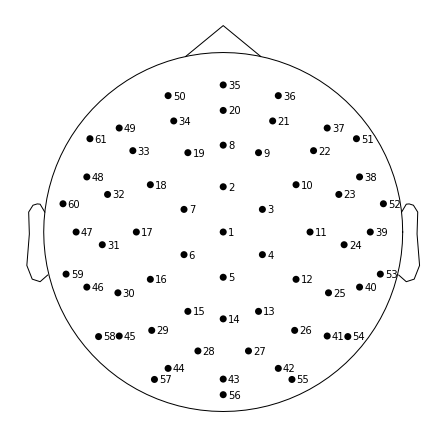

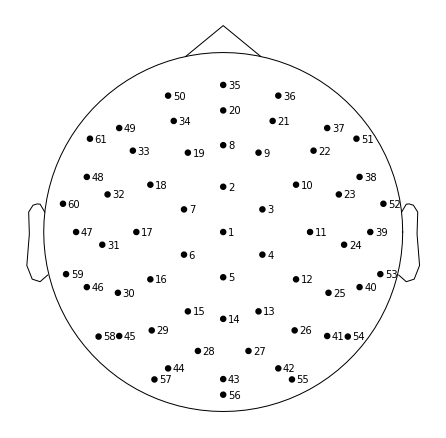

In [81]:
mne.viz.plot_montage(montage)

In [73]:
def plot_coefs(df, sensors: List[str], facet=True, ci=95, **kwargs):
    to_plot = df[df.sensor.isin(sensors) & ~df.feature.str.startswith("binned")].sort_values("sensor")
    
    if facet:
        g = sns.FacetGrid(data=to_plot.reset_index(), row="sensor",
                          sharex=True, sharey=True, height=7)
        g.map(sns.lineplot, "epoch_time", "coef", "feature",
              ci=ci, **kwargs)
        g.add_legend()
        
        axes = g.axes.flat
        ret = g
    else:
        ax = sns.lineplot(data=to_plot.reset_index(),
                          x="epoch_time", y="coef", hue="feature",
                          ci=ci, **kwargs)
        axes = [ax]
        ret = ax

    for ax in axes:
        ax.set_xlabel("Epoch time")
        ax.set_ylabel("TRF coefficient")
        
        ax.axhline(0, c="gray", alpha=0.3)
        ax.axvline(0, c="gray", alpha=0.3)
        ax.axvline(0.3, c="gray", alpha=0.3, linestyle="dashed")
        ax.axvline(0.5, c="gray", alpha=0.3, linestyle="dashed")
        
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f"TRF weights, avg over {len(to_plot.subject.unique())} subjects $\\times$ {len(to_plot.split.unique())} CV folds")
    plt.tight_layout()
        
    return ret

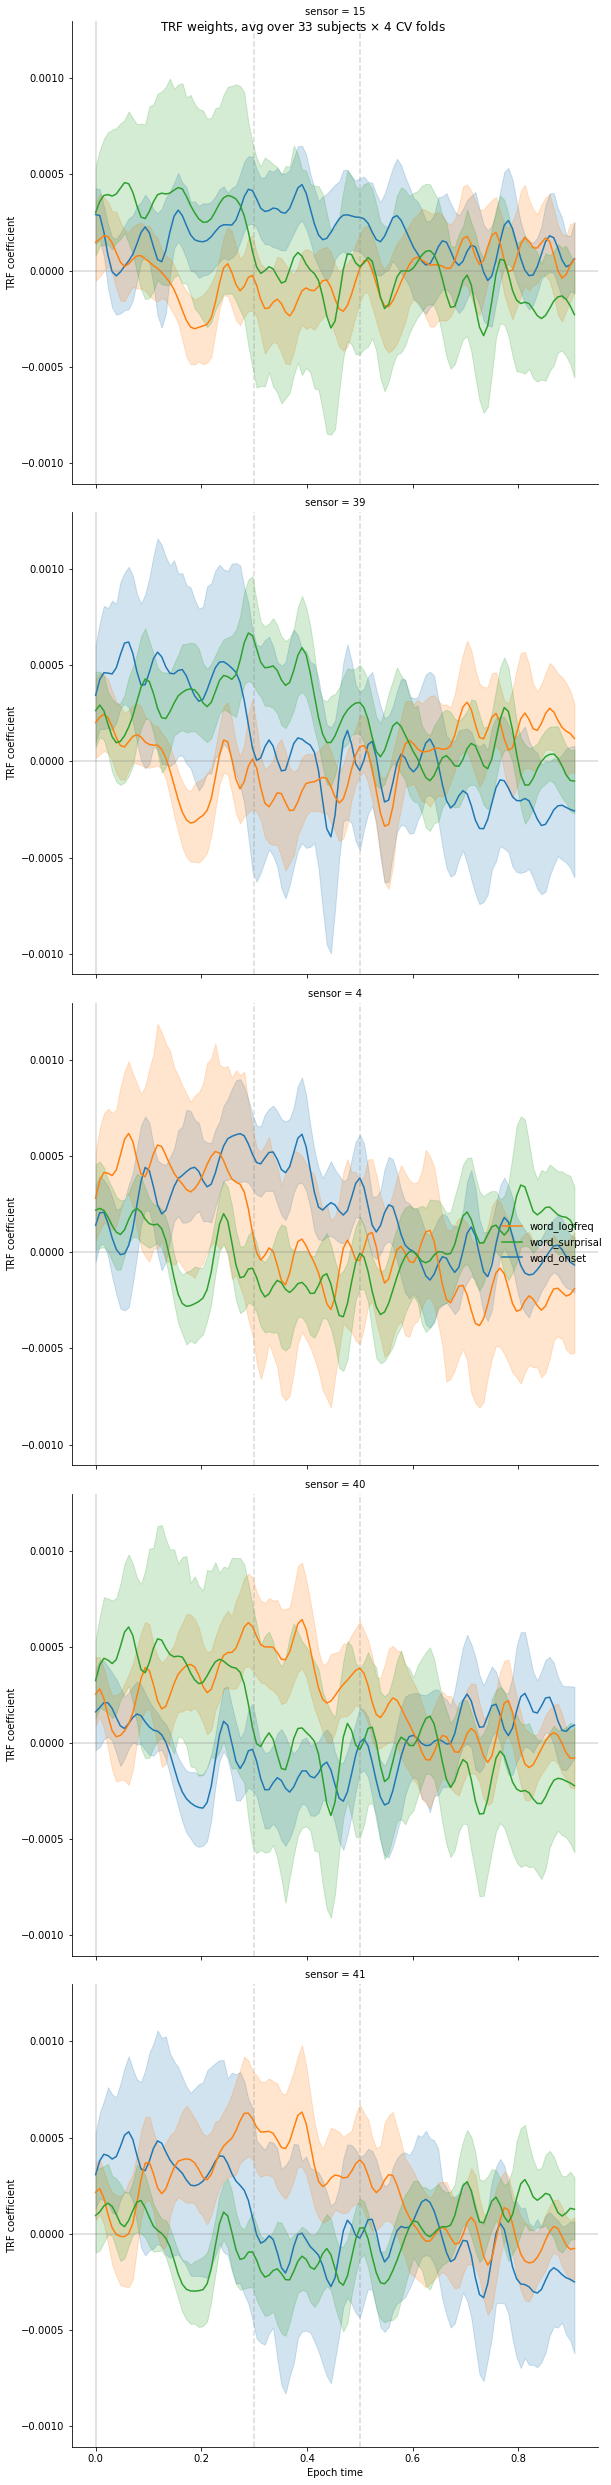

In [78]:
plot_sensors = most_negative_sensors.loc[target_feature].index.get_level_values("sensor")
plot_features = ["word_onset", "word_logfreq", "word_surprisal"]
g = plot_coefs(df[df.feature.isin(plot_features)], sensors=plot_sensors, facet=True)
# g.savefig("fit_mne_trf_bestsurp.png")

In [76]:
df.sensor.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57',
       '58', '59', '60', '61', 'VEOG'], dtype=object)

<AxesSubplot:xlabel='Epoch time', ylabel='TRF coefficient'>

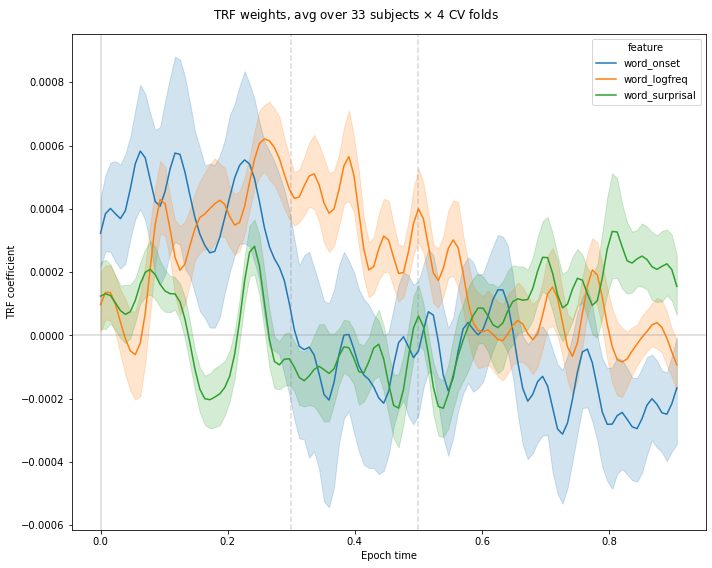

In [83]:
# Use sensors tested in paper; average together
plot_sensors = ["1", "4", "5", "6"]
plot_features = ["word_onset", "word_logfreq", "word_surprisal"]
plt.subplots(figsize=(10, 8))
plot_coefs(df[df.feature.isin(plot_features)],
           sensors=plot_sensors, facet=False, hue_order=plot_features)

In [146]:
df = pd.concat([pd.DataFrame(feature_trf).rename_axis(index="sensor", columns="trf_sample").unstack().rename("coef")
                for feature_trf in best_rf.coef_.transpose((1, 0, 2))],
               keys=rf.feature_names, names=["feature", "trf_sample", "sensor"])
df = pd.DataFrame(df).reset_index()
df["epoch_time"] = df.trf_sample.map(dict(enumerate(best_rf.delays_ / best_rf.sfreq)))

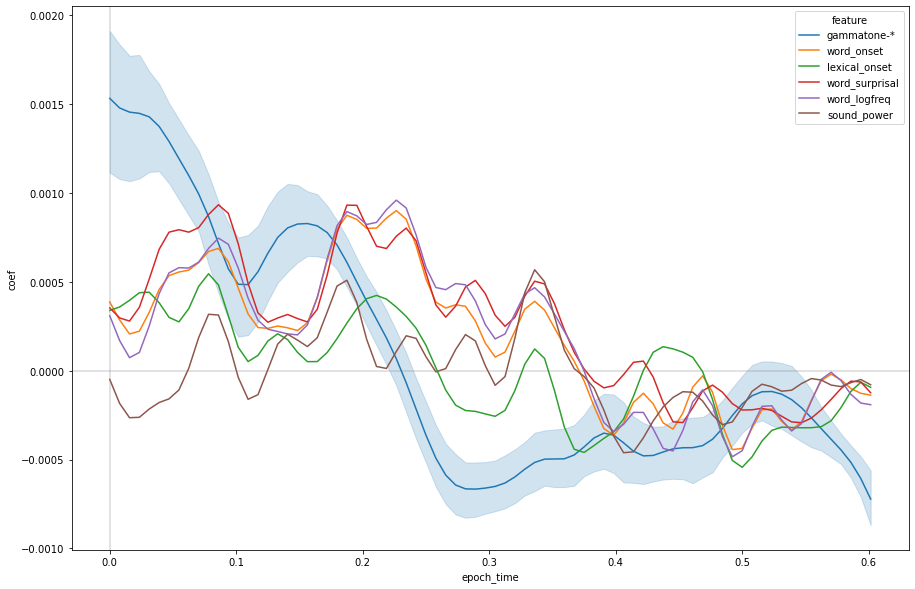

In [147]:
plt.subplots(figsize=(15, 10))

to_plot = df[df.sensor == 4].copy()
to_plot["feature"] = to_plot.feature.str.replace(r"gammatone-.*", "gammatone-*", regex=True)
ax = sns.lineplot(data=to_plot.reset_index(),
                  x="epoch_time", y="coef", hue="feature")

ax.axhline(0, c="gray", alpha=0.3)
ax.axvline(0, c="gray", alpha=0.3)

In [171]:
def prepare_control_predictors(dataset, subject_id):
    # Merge in segment onset data for subject.
    segment_onsets = dataset.get_presentation_data(subject_id).groupby("segment_idx").segment_onset.min()
    
    ret = extra_predictors.copy()
    ret["time"] += ret.segment.map(segment_onsets)
    
    # Drop control predictors for which there is no annotation data.
    # This is the case for some subjects with missing presentation / EEG data.
    ret = ret.dropna()
    
    sfreq = dataset._raw_data[subject_id].info["sfreq"]
    ret["sample"] = (ret.time * sfreq).astype(int)
    ret["feature"] = ret.feature.str.cat(ret.variable, sep="-")
    # resample within frequency bins
    ret = ret.groupby(["segment", "feature", "sample"]).value.mean().reset_index()
    
    return ret.pivot(["segment", "sample"], "feature", "value").reset_index()


last_rf = None
def estimate_trf_coefs(dataset, subject_id):
    raw = dataset._raw_data[subject_id]
    Y, _ = raw["eeg"][:]
    
    p_df = data.get_presentation_data(subject_id)
    p_df["sample_idx"] = np.floor(p_df.onset * raw.info["sfreq"]).astype(int)
    
    # Prepare predictors.
    features = ["word_onset", "lexical_onset", "word_surprisal", "word_logfreq", "sound_power"]
    stim_seq = np.zeros((len(features), Y.shape[1]))
    stim_seq[0, p_df.sample_idx] = 1
    stim_seq[1:, p_df.sample_idx] = \
        p_df[["IsLexical", "NGRAM", "LogFreq", "SndPower"]].T.fillna(0.)
    
    control_features_df = prepare_control_predictors(dataset, subject_id)
    control_features = list(set(control_features_df.columns) - {"segment", "sample"})
    control_stim_seq = np.zeros((len(control_features), Y.shape[1]))
    control_stim_seq[:, control_features_df["sample"]] = control_features_df[control_features].T
    
    features = features + control_features
    stim_seq = np.concatenate([stim_seq, control_stim_seq], axis=0)
    
    # TODO CV
    rf = ReceptiveField(*RF_WINDOW, sfreq=raw.info["sfreq"],
                    feature_names=features,
                    estimator=1.,
                    scoring="corrcoef")
    rf.fit(stim_seq.T, Y.T)
    
    rf_ch_names = np.array(raw.ch_names)[mne.io.pick.pick_types(raw.info, eeg=True)].tolist()

    df = pd.concat([pd.DataFrame(feature_trf, index=rf_ch_names).rename_axis(index="sensor", columns="trf_sample").unstack().rename("coef")
                    for feature_trf in rf.coef_.transpose((1, 0, 2))],
                   keys=rf.feature_names, names=["feature", "trf_sample", "sensor"])
    df = pd.DataFrame(df).reset_index()
    df["subject_id"] = subject_id
    df["epoch_time"] = df.trf_sample.map(dict(enumerate(rf.delays_ / rf.sfreq)))
    
    return df

In [173]:
def estimate_all_trf_coefs(dataset):
    subject_ids = tqdm(dataset._raw_data.keys())
    df = pd.concat([estimate_trf_coefs(dataset, subject_id) for subject_id in subject_ids])
    return df

In [174]:
df = estimate_all_trf_coefs(data)

  0%|          | 0/33 [00:00<?, ?it/s]

In [175]:
df

,feature,trf_sample,sensor,coef,subject_id,epoch_time
0,word_onset,0,1,1.097796e-06,1,-0.1
1,word_onset,0,2,1.349072e-07,1,-0.1
2,word_onset,0,3,1.174749e-06,1,-0.1
3,word_onset,0,4,1.660104e-06,1,-0.1
4,word_onset,0,5,1.852451e-06,1,-0.1
...,...,...,...,...,...,...
342449,gammatone-8-v4,400,58,1.050517e-08,48,0.7
342450,gammatone-8-v4,400,59,1.171209e-08,48,0.7
342451,gammatone-8-v4,400,60,1.151278e-08,48,0.7
342452,gammatone-8-v4,400,61,2.021735e-08,48,0.7


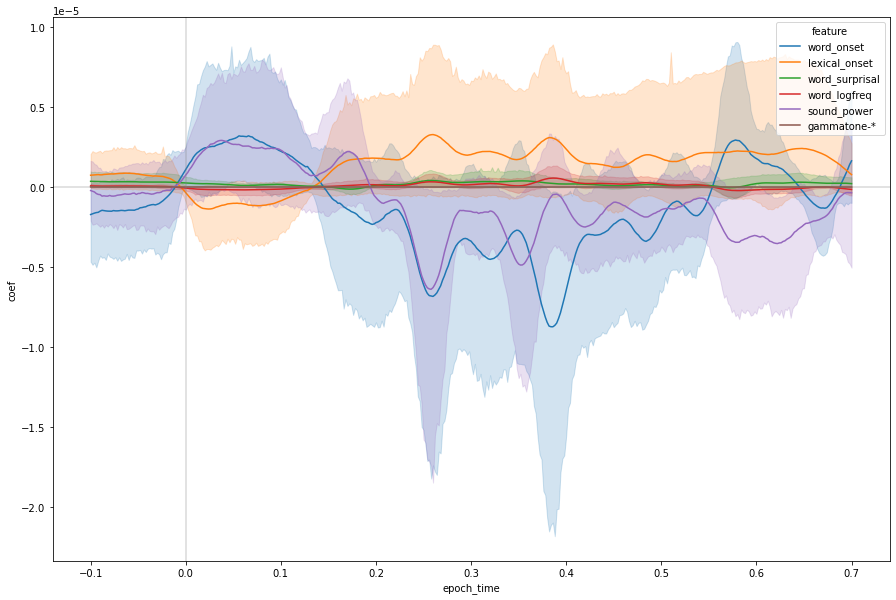

In [177]:
plt.subplots(figsize=(15, 10))

to_plot = df[df.sensor == "2"].copy()
to_plot["feature"] = to_plot.feature.str.replace(r"gammatone-.*", "gammatone-*", regex=True)
ax = sns.lineplot(data=to_plot.reset_index(),
                  x="epoch_time", y="coef", hue="feature")

ax.axhline(0, c="gray", alpha=0.3)
ax.axvline(0, c="gray", alpha=0.3)

In [99]:
df["abs_coef"] = df.coef.abs()
df.xs("word_surprisal", level='feature').groupby(["sensor", "trf_sample"]).abs_coef.median() \
    .groupby("sensor").max().sort_values(ascending=False)

sensor
60    1.975188e-07
8     1.906027e-07
22    1.866720e-07
59    1.844132e-07
23    1.795546e-07
          ...     
28    7.289585e-08
27    6.914907e-08
26    6.209745e-08
25    5.891675e-08
29    4.787024e-08
Name: abs_coef, Length: 61, dtype: float64

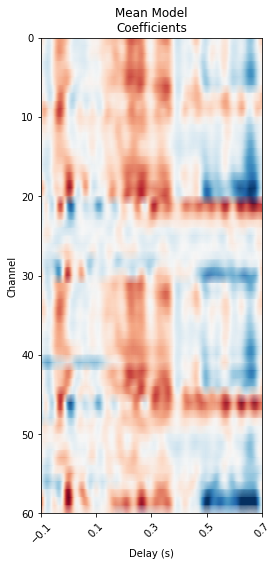

In [57]:
# TODO CV
# get coefficients for 0th feature across all sensors.
# shape: n_sensors * n_trf_samples
mean_coefs = rf.coef_[:, 0, :]
times = rf.delays_ / float(rf.sfreq)
ix_chs = np.arange(mean_coefs.shape[0])

fig, ax = plt.subplots(figsize=(4, 8))
max_coef = mean_coefs.max()
ax.pcolormesh(times, ix_chs, mean_coefs, cmap='RdBu_r',
              vmin=-max_coef, vmax=max_coef, shading='gouraud')
tmin, tmax = RF_WINDOW
ax.set(xlabel='Delay (s)', ylabel='Channel', title="Mean Model\nCoefficients",
       xlim=times[[0, -1]], ylim=[len(ix_chs) - 1, 0],
       xticks=np.arange(tmin, tmax + .2, .2))
plt.setp(ax.get_xticklabels(), rotation=45)
mne.viz.tight_layout()

In [53]:
mean_coefs.shape

(61, 401)